# 課題6: ディープラーニングのモデルを構築しよう

今回の課題では手書き数字の認識を、CNNを用いて行います。ただし本課題では、レッスン本編で用いたscikit-learnのものではなく、Kerasのデータセットに含まれている、より大きいサイズの手書き数字データで課題を進めていただきます。

下記にKerasから手書き数字のデータセットをダウンロードするコードが記載されています。このデータを用いてディープラーニングのモデルを構築してください。

今までのレッスンで学んだ内容を踏まえ、各セルにコードを埋めていってください。

（※`変更しないでください`と書かれたセルには、コードの追記変更をしないでください）

## 1. ライブラリのimport

In [1]:
# （変更しないでください）

# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TensorFlow
import tensorflow as tf

# データの分割
from sklearn.model_selection import train_test_split

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

In [ ]:
# 追加インポート（課題に必要／別セル想定のためここで追記）
import os, random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# ==== 乱数固定 ここから ====
# 任意の整数 or None を設定。None の場合は非固定で実行。
USER_SEED = 42   # 例: 42 / 1234 / None

def set_global_seed(seed):
    """seed が None なら何もしない。int なら各所の乱数を固定。"""
    if seed is None:
        print("乱数シード: なし（非固定）")
        return
    import os, random
    os.environ["PYTHONHASHSEED"] = str(seed)  # 一部はプロセス起動時のみ有効
    np.random.seed(seed)
    random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except Exception as e:
        print("tf.random.set_seed の設定で例外:", e)
    print(f"乱数シード: {seed} を設定しました")

set_global_seed(USER_SEED)
# ==== 乱数固定 ここまで ====

# 日本語フォント設定（文字化け対策）
from matplotlib import font_manager
jp_candidates = [
    "Hiragino Sans", "Hiragino Kaku Gothic ProN", "Hiragino Maru Gothic ProN",
    "YuGothic", "Noto Sans CJK JP", "IPAexGothic", "IPAGothic", "TakaoGothic", "AppleGothic"
]
available_fonts = set(f.name for f in font_manager.fontManager.ttflist)
for f in jp_candidates:
    if f in available_fonts:
        plt.rcParams["font.family"] = f
        break
plt.rcParams["axes.unicode_minus"] = False


ランダムシードを 42 に固定しました。


## 2. データの読み込み

Kerasのデータセットは、あらかじめTraining setとTest setに分けられています。戻り値はタプルで取得できます。

In [3]:
# Kerasに添付されている手書き数字のデータセットをダウンロードして読み込む
# （変更しないでください）
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 3. データの確認

In [4]:
# X_train, Y_train, X_test, Y_testの形状を確認
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape :", X_test.shape)
print("Y_test.shape :", Y_test.shape)

X_train.shape: (60000, 28, 28)
Y_train.shape: (60000,)
X_test.shape : (10000, 28, 28)
Y_test.shape : (10000,)


In [8]:
# X_trainの先頭1行を表示
print("X_train[0] (28x28画素の数値配列):")
for row in X_train[0]:
    # 3桁右寄せで揃える（見やすさ向上）
    print("[" + " ".join(f"{int(v):3d}" for v in row) + "]")

X_train[0] (28x28画素の数値配列):
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
[  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
[  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
[  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 

In [7]:
# Y_trainの先頭1行を表示
print("Y_train[0] (ラベル):", Y_train[0])

Y_train[0] (ラベル): 5


データセットを可視化して表示します。

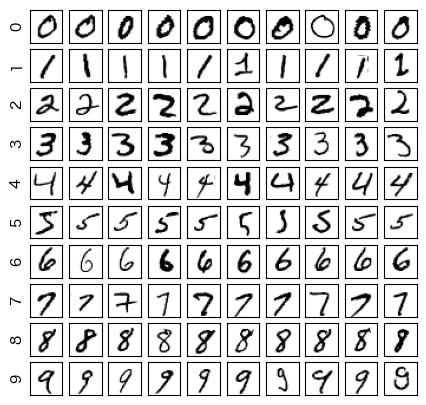

In [9]:
# （変更しないでください）

# 「数字:空のリスト」の辞書を作成する
images = {label: [] for label in range(0,10)}

# 総イメージ数
image_count = 0

# それぞれの数字のリストに、説明変数をappendしていく
for i in range(0, len(X_train)):
    if len(images[Y_train[i]]) < 10:
        images[Y_train[i]].append(X_train[i])
        image_count += 1
        if image_count == 100:
            break

# 10行10列にグラフを分割
fig, ax = plt.subplots(10, 10, figsize=(5, 5))

for i in range(10):
    # ラベル
    ax[i, 0].set_ylabel(i)

    for j in range(10):
        # 行=i、列=jの位置に画像を描画する
        ax[i, j].imshow(images[i][j].reshape(28, 28), cmap='Greys')

        # 目盛を表示しない設定
        ax[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.show()

## 4. データの前処理

In [11]:
# len関数を使い、X_trainを(X_trainの長さ, 28, 28, 1)にreshapeしてX_train2に代入
X_train2 = X_train.reshape(len(X_train), 28, 28, 1)

# len関数を使い、X_testを(X_testの長さ, 28, 28, 1)にreshapeしてX_test2に代入
X_test2 = X_test.reshape(len(X_test), 28, 28, 1)

In [12]:
# to_categoricalを使い、Y_trainをカテゴリー変数に展開してY_train2に代入
Y_train2 = to_categorical(Y_train, num_classes=10)

# to_categoricalを使い、Y_testをカテゴリー変数に展開してY_test2に代入
Y_test2 = to_categorical(Y_test, num_classes=10)

In [13]:
# X_train2, Y_train2, X_test2, Y_test2の形状を確認
print("X_train2.shape:", X_train2.shape)
print("Y_train2.shape:", Y_train2.shape)
print("X_test2.shape :", X_test2.shape)
print("Y_test2.shape :", Y_test2.shape)

X_train2.shape: (60000, 28, 28, 1)
Y_train2.shape: (60000, 10)
X_test2.shape : (10000, 28, 28, 1)
Y_test2.shape : (10000, 10)


In [14]:
# train_test_splitを使い、学習データと検証データに7:3（検証データが3割）で分割する
# （詳細：データ(X_train2、Y_train2)を「X_train2, X_valid2, Y_train2, Y_valid2」に分割）
X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(
    X_train2, Y_train2, test_size=0.3, random_state=42, stratify=Y_train
)

In [15]:
# X_train2, Y_train2, X_valid2, Y_valid2, X_test2, Y_test2の形状を確認
print("X_train2:", X_train2.shape)
print("Y_train2:", Y_train2.shape)
print("X_valid2:", X_valid2.shape)
print("Y_valid2:", Y_valid2.shape)
print("X_test2 :", X_test2.shape)
print("Y_test2 :", Y_test2.shape)

X_train2: (42000, 28, 28, 1)
Y_train2: (42000, 10)
X_valid2: (18000, 28, 28, 1)
Y_valid2: (18000, 10)
X_test2 : (10000, 28, 28, 1)
Y_test2 : (10000, 10)


## 5. モデルの構築

Kerasを使ってモデルを構築してみましょう。以下を条件とします：

- CNN(Conv2D)を使うこと
- 正解率(accuracy)が50%以上であること

場合によっては、学習にものすごく時間がかかる場合もあります。適宜、パラメータ数を調整して行なってください。

In [16]:
# （モデルの初期化から構築までのコードを、このセル以下に記述してください）
model = models.Sequential(name="mnist_cnn")
# 入力: (28,28,1)
model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(28,28,1)))
model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

/Users/rtakamot/project/ai-training/AIDEV/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# モデルの構造を表示
model.summary()

Model: "mnist_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
%%time
# 学習の実施(ものすごく時間がかかる場合もあります)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
log = model.fit(  
    X_train2, Y_train2,
    validation_data=(X_valid2, Y_valid2),
    epochs=50, # 必要に応じて小さく
    batch_size=64, # CPUなら64程度から
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50


2025-09-19 13:36:04.779540: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-19 13:36:04.780069: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

657/657 - 22s - 34ms/step - accuracy: 0.8544 - loss: 0.5582 - val_accuracy: 0.9776 - val_loss: 0.0748
Epoch 2/50
657/657 - 22s - 34ms/step - accuracy: 0.9597 - loss: 0.1380 - val_accuracy: 0.9848 - val_loss: 0.0517
Epoch 3/50
657/657 - 23s - 36ms/step - accuracy: 0.9703 - loss: 0.1010 - val_accuracy: 0.9856 - val_loss: 0.0479
Epoch 4/50
657/657 - 24s - 36ms/step - accuracy: 0.9752 - loss: 0.0837 - val_accuracy: 0.9867 - val_loss: 0.0460
Epoch 5/50
657/657 - 24s - 37ms/step - accuracy: 0.9785 - loss: 0.0731 - val_accuracy: 0.9874 - val_loss: 0.0445
Epoch 6/50
657/657 - 25s - 38ms/step - accuracy: 0.9811 - loss: 0.0666 - val_accuracy: 0.9893 - val_loss: 0.0414
Epoch 7/50
657/657 - 24s - 37ms/step - accuracy: 0.9815 - loss: 0.0616 - val_accuracy: 0.9879 - val_loss: 0.0457
Epoch 8/50
657/657 - 23s - 36ms/step - accuracy: 0.9811 - loss: 0.0641 - val_accuracy: 0.9897 - val_loss: 0.0367
Epoch 9/50
657/657 - 24s - 37ms/step - accuracy: 0.9839 - loss: 0.0540 - val_accuracy: 0.9906 - val_loss: 0

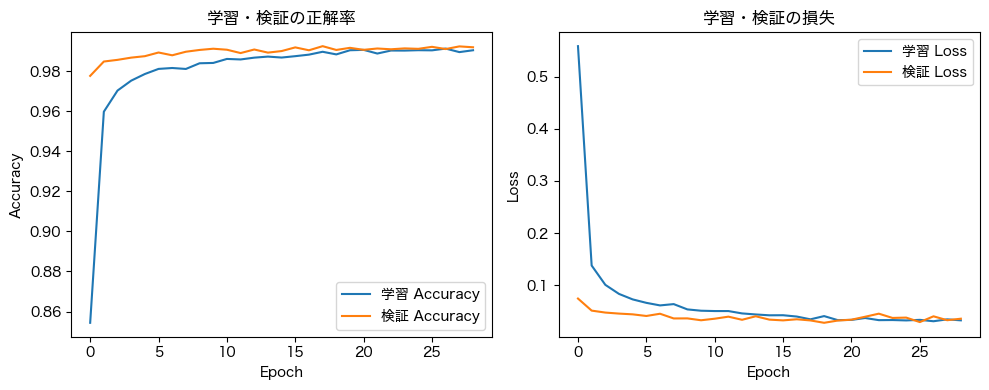

In [19]:
# 学習過程をグラフ表示
hist = log.history
acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist[acc_key], label="学習 Accuracy")
plt.plot(hist[val_acc_key], label="検証 Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("学習・検証の正解率"); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["loss"], label="学習 Loss")
plt.plot(hist["val_loss"], label="検証 Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("学習・検証の損失"); plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# predictを使い、X_test2をもとに予測した結果を、
# カテゴリー変数へ復元してY_pred2に代入
y_proba = model.predict(X_test2, verbose=0)
Y_pred2 = np.argmax(y_proba, axis=1)

2025-09-19 14:25:05.526501: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-19 14:25:05.526935: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [21]:
# Y_test2もカテゴリー変数へ復元して、Y_test2_ に代入
Y_test2_ = np.argmax(Y_test2, axis=1)

In [23]:
# classification_reportを使い、モデルの評価を実施
print("\n=== Classification Report (Test) ===")
print(classification_report(Y_test2_, Y_pred2, digits=2))


=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      0.99      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

